# Exercise - glacial isostatic adjustment
## Task description
In this exercise, we want to estimate the land uplift of Scandinavia.

Therefore, we use GPS station coordinate time series.
The stations are located in Scandinavia.
Based on the trend of the height coordinate, the glacial isostatic adjustment should be determined.

GPS data is used from the Nevada Geodetic Laboratory: http://geodesy.unr.edu/NGLStationPages/GlobalStationList

# Some background information

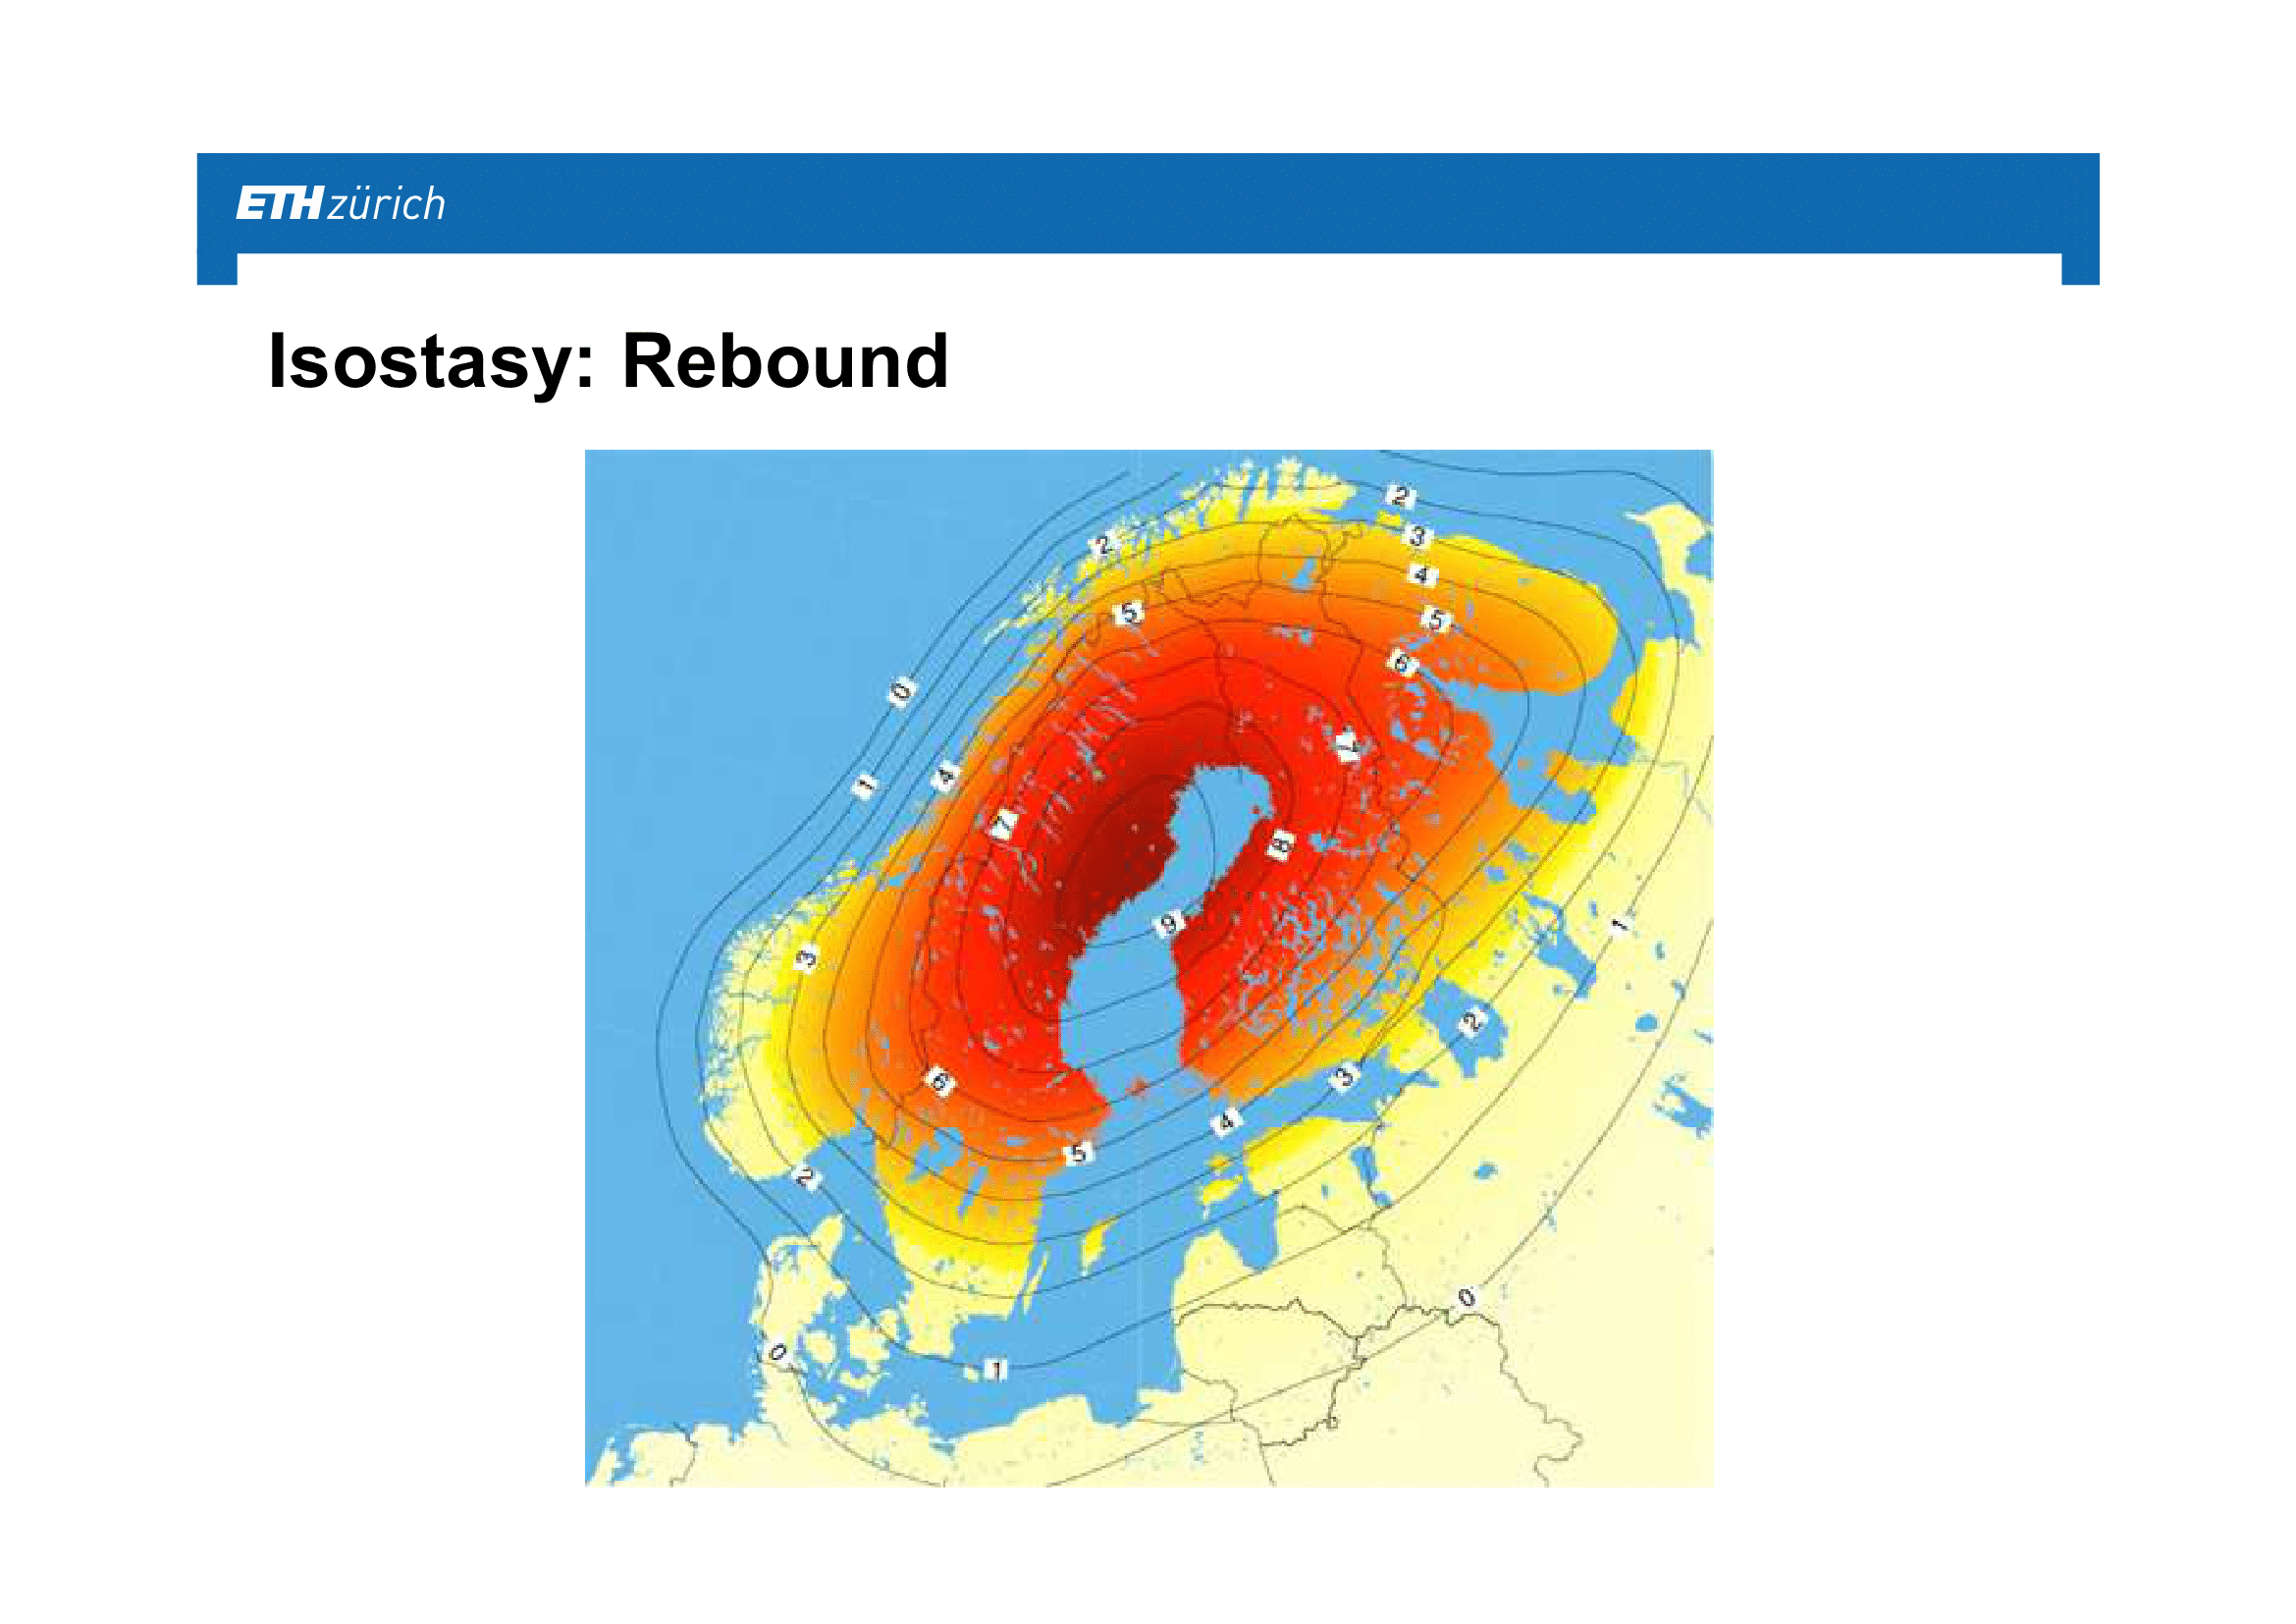

In [1]:
from IPython.display import Image
Image(filename='../Images/isostasy.png', width=800)

# Let's start programming

In [2]:
# import packages
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [3]:
# function to read the data
def read_txyz2(file):
    """
    This function reads .txyz2 files and returns a pd.DataFrame of the data.
    :param file: (PosixPath) path to .txyz2 file
    :return: (pd.DataFrame)
    """
    # read data (txyz2 format)
    dateparser = lambda x: datetime.datetime.strptime(x, '%y%b%d')
    df = pd.read_csv(file, delimiter=' ', skipinitialspace=True, index_col=1, parse_dates=True, date_parser=dateparser,
                     names=['station', 'decimal_year', 'x(m)', 'y(m)', 'z(m)', 'sig_x(m)', 'sig_y(m)', 'sig_z(m)',
                            'corr_xy', 'corr_yz', 'corr_xz', 'ant(m)'])
    df.name = file.stem

    return df

# Read in the data and inspect it

In [4]:
# read data
file_station1 = Path("../Data/RAT0.txyz2")
file_station2 = Path("../Data/TRDS.txyz2")
station1 = read_txyz2(file=file_station1)
station2 = read_txyz2(file=file_station2)
# show first lines of data
station1.head()

station  decimal_year          x(m)          y(m)          z(m)  \
2006-06-09    RAT0     2006.4367  2.620558e+06  1.000462e+06  5.709039e+06   
2006-06-10    RAT0     2006.4394  2.620558e+06  1.000462e+06  5.709039e+06   
2006-06-11    RAT0     2006.4422  2.620558e+06  1.000462e+06  5.709039e+06   
2006-06-13    RAT0     2006.4476  2.620558e+06  1.000462e+06  5.709039e+06   
2006-06-14    RAT0     2006.4504  2.620558e+06  1.000462e+06  5.709039e+06   

            sig_x(m)  sig_y(m)  sig_z(m)   corr_xy   corr_yz   corr_xz  ant(m)  
2006-06-09  0.001914  0.001270  0.004510  0.484934  0.485564  0.712201   0.071  
2006-06-10  0.001253  0.000839  0.002823  0.503393  0.496349  0.703521   0.071  
2006-06-11  0.001265  0.000848  0.002855  0.498931  0.499558  0.709311   0.071  
2006-06-13  0.001306  0.000891  0.002930  0.519542  0.528540  0.715371   0.071  
2006-06-14  0.001287  0.000863  0.002882  0.497355  0.507627  0.711544   0.071

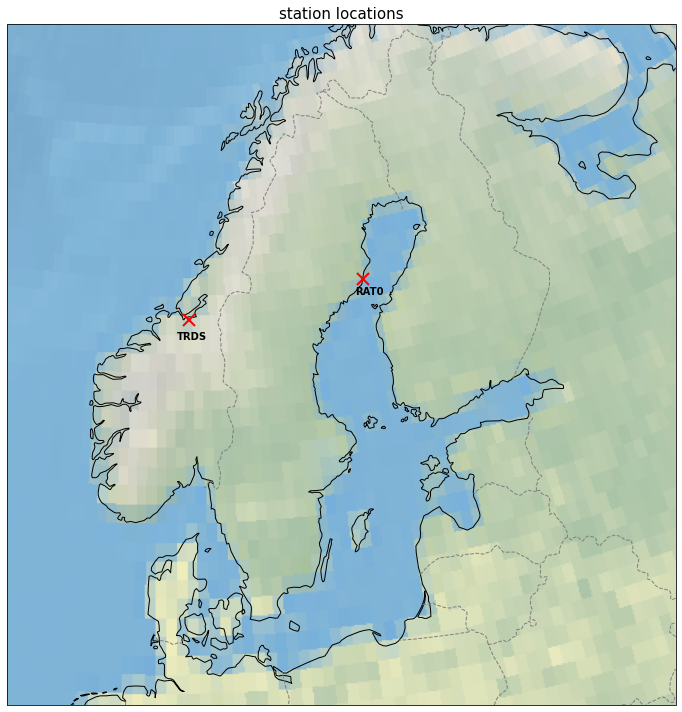

In [5]:
# plot map showing where the two stations are located
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lonlat_1 = (20.896, 63.986)
lonlat_2 = (10.319, 63.371)

plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.EuroPP())
ax.stock_img()
ax.set_extent([2, 40, 53, 90])

plt.plot(lonlat_1[0], lonlat_1[1], color='r', linewidth=2, marker='x', markersize=12, markeredgewidth=2, transform=ccrs.Geodetic())
plt.plot(lonlat_2[0], lonlat_2[1], color='r', linewidth=2, marker='x', markersize=12, markeredgewidth=2, transform=ccrs.Geodetic())
plt.text(lonlat_1[0] + 1, lonlat_1[1] - 0.5, station1.name, horizontalalignment='right', weight='bold', transform=ccrs.Geodetic())
plt.text(lonlat_2[0] + 1, lonlat_2[1] - 0.5, station2.name, horizontalalignment='right', weight='bold', transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')
plt.title('station locations', fontsize=15)
plt.tight_layout()

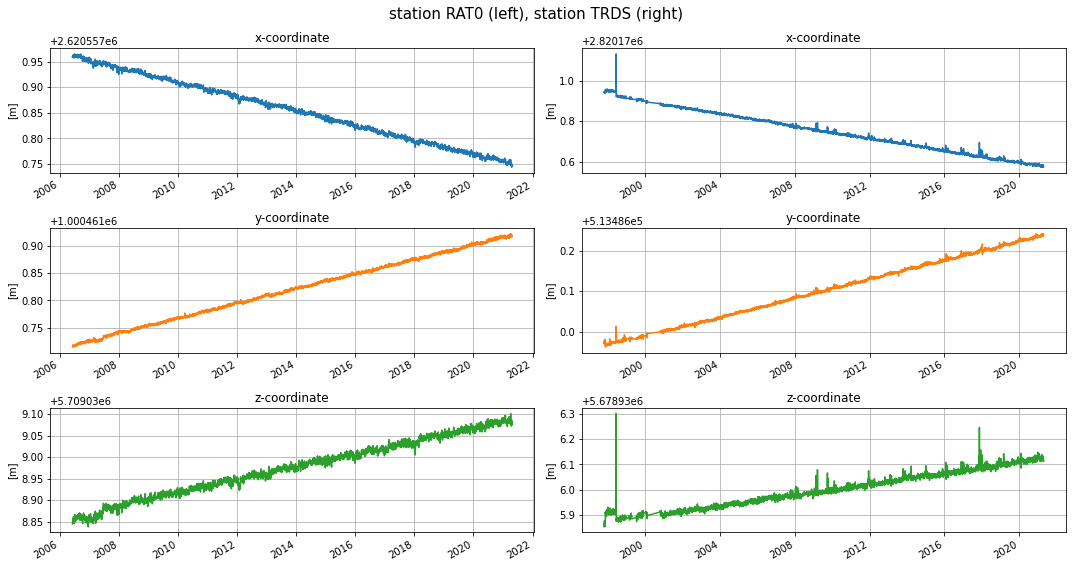

In [6]:
# plot time series to inspect the data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
station1['x(m)'].plot(ax=axes[0,0], color='C0', title='x-coordinate', xlabel='', ylabel='[m]', grid=True)
station1['y(m)'].plot(ax=axes[1,0], color='C1', title='y-coordinate', xlabel='', ylabel='[m]', grid=True)
station1['z(m)'].plot(ax=axes[2,0], color='C2', title='z-coordinate', xlabel='', ylabel='[m]', grid=True)
station2['x(m)'].plot(ax=axes[0,1], color='C0', title='x-coordinate', xlabel='', ylabel='[m]', grid=True)
station2['y(m)'].plot(ax=axes[1,1], color='C1', title='y-coordinate', xlabel='', ylabel='[m]', grid=True)
station2['z(m)'].plot(ax=axes[2,1], color='C2', title='z-coordinate', xlabel='', ylabel='[m]', grid=True)
plt.suptitle('station {} (left), station {} (right)'.format(station1.name, station2.name), fontsize=15)
plt.tight_layout()

# Transformation: $(x,y,z) \rightarrow (east,north,up)$

1. Transform: $(x,y,z) \rightarrow (\phi,\lambda,h$)
2. Transform: $(\phi,\lambda,h) \rightarrow (east,north,up)$

**Formulas:**

$\lambda=arctan(\frac{y}{x})$

$\phi=arcsin(\frac{z}{\sqrt{x²+y²+z²}})$

$h=\sqrt{x²+y²+z²}-R_{Earth}$

\begin{equation}
\begin{bmatrix}
e \\
n \\
u \\
\end{bmatrix}
=
\begin{bmatrix}
-sin\lambda & cos\lambda & 0\\
-sin\phi cos\lambda & -sin\phi sin\lambda & cos\phi \\
cos\phi cos\lambda & cos \phi sin\lambda & sin \phi
\end{bmatrix}
\begin{bmatrix}
x-x_{ref} \\
y-y_{ref} \\
z-z_{ref} \\
\end{bmatrix}
\end{equation}

In [7]:
# STATION 1 (RAT0)
# xyz to phi, lambda, height
col_xyz = ['x(m)', 'y(m)', 'z(m)']
# we define a reference and calculate phi, lambda, height for that reference
ref = station1[col_xyz].iloc[0]  
l_ref = np.arctan2(ref['y(m)'], ref['x(m)'])
phi_ref = np.arcsin(ref['z(m)'] / np.sqrt((ref[col_xyz]**2).sum()))

In [8]:
# rotation matrix
R = np.full(shape=(3, 3), fill_value=np.nan)
R[0, :] = np.array((-np.sin(l_ref), np.cos(l_ref), 0))
R[1, :] = np.array((-np.sin(phi_ref)*np.cos(l_ref), -np.sin(phi_ref)*np.sin(l_ref), np.cos(phi_ref)))
R[2, :] = np.array((np.cos(phi_ref)*np.cos(l_ref), np.cos(phi_ref)*np.sin(l_ref), np.sin(phi_ref)))

S = station1[col_xyz]-ref[col_xyz]

# matrix multiplication
enu = R@S.T
station1 = enu.T
station1.columns = ['east(m)', 'north(m)', 'up(m)']

In [9]:
# STATION 2 (TRDS)
# we define a reference and calculate phi, lambda, height for that reference
ref = station2[col_xyz].iloc[0]
l_ref = np.arctan2(ref['y(m)'], ref['x(m)'])
phi_ref = np.arcsin(ref['z(m)'] / np.sqrt((ref[col_xyz]**2).sum()))

In [10]:
# rotation matrix
R = np.full(shape=(3, 3), fill_value=np.nan)
R[0, :] = np.array((-np.sin(l_ref), np.cos(l_ref), 0))
R[1, :] = np.array((-np.sin(phi_ref)*np.cos(l_ref), -np.sin(phi_ref)*np.sin(l_ref), np.cos(phi_ref)))
R[2, :] = np.array((np.cos(phi_ref)*np.cos(l_ref), np.cos(phi_ref)*np.sin(l_ref), np.sin(phi_ref)))

S = station2[col_xyz]-ref[col_xyz]

# matrix multiplication
enu = R@S.T
station2 = enu.T
station2.columns = ['east(m)', 'north(m)', 'up(m)']

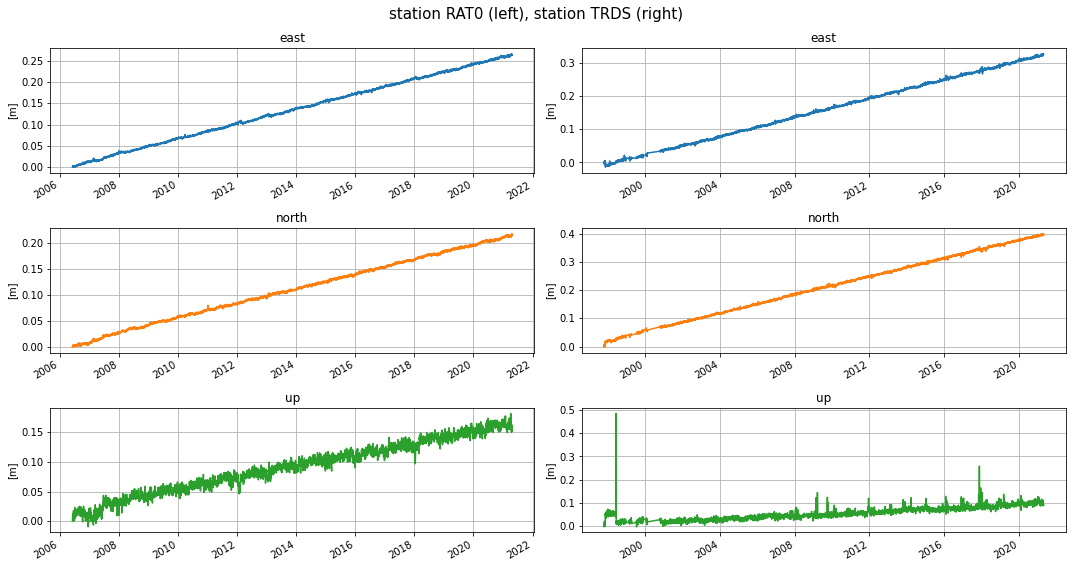

In [11]:
# plot time series to inspect the data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
station1['east(m)'].plot(ax=axes[0,0], color='C0', title='east', xlabel='', ylabel='[m]', grid=True)
station1['north(m)'].plot(ax=axes[1,0], color='C1', title='north', xlabel='', ylabel='[m]', grid=True)
station1['up(m)'].plot(ax=axes[2,0], color='C2', title='up', xlabel='', ylabel='[m]', grid=True)
station2['east(m)'].plot(ax=axes[0,1], color='C0', title='east', xlabel='', ylabel='[m]', grid=True)
station2['north(m)'].plot(ax=axes[1,1], color='C1', title='north', xlabel='', ylabel='[m]', grid=True)
station2['up(m)'].plot(ax=axes[2,1], color='C2', title='up', xlabel='', ylabel='[m]', grid=True)
plt.suptitle('station RAT0 (left), station TRDS (right)', fontsize=15)
plt.tight_layout()

# What do you see?
- How do the time series look like?
- What can you say about them by visually inspecting them?
- How long are the time series?
- Are there any outliers or breaks in the time series? How do we deal with that?
- ...

# Outlier elimination

Idea: 
- First, we calculate a floating median of the time series. This is done because the median is robust against outliers. 
- Based on the difference between the floating median and the observations we can decide if they are outliers or not.
- Therefore, we need to know the noise floor of the time series. This can be calculated based on the median of a floating standard deviation.

Alternatively, you could do an iterative least squares adjustment including outlier detection.

In [12]:
# generate equidistant time series (missing values)
idx1 = pd.date_range(station1.index[0], station1.index[-1])
idx2 = pd.date_range(station2.index[0], station2.index[-1])

col_enu = ['east(m)', 'north(m)', 'up(m)']
station1 = station1[col_enu].reindex(idx1)
station2 = station2[col_enu].reindex(idx2)

# get overlapping time period
idx = station1.index.intersection(station2.index)
station1 = station1[col_enu].reindex(idx)
station2 = station2[col_enu].reindex(idx)

station1

east(m)  north(m)     up(m)
2006-06-09  0.000000  0.000000  0.000000
2006-06-10 -0.000210  0.001234  0.002313
2006-06-11 -0.000092  0.000858  0.009233
2006-06-12       NaN       NaN       NaN
2006-06-13  0.001980  0.001471  0.013077
...              ...       ...       ...
2021-04-13  0.264071  0.213670  0.154859
2021-04-14  0.265451  0.214706  0.153213
2021-04-15  0.264808  0.212383  0.149109
2021-04-16  0.265551  0.213322  0.150862
2021-04-17  0.266000  0.213974  0.153663

[5427 rows x 3 columns]

In [13]:
# calculate floating median
col_median = ['median_e', 'median_n', 'median_u']
station1[col_median] = station1[col_enu].rolling(window=30, center=True, min_periods=15).median()
station2[col_median] = station2[col_enu].rolling(window=30, center=True, min_periods=15).median()

# interpolate floating median
station1[col_median] = station1[col_median].interpolate(limit_direction='both')
station2[col_median] = station2[col_median].interpolate(limit_direction='both')

station1.head()

east(m)  north(m)     up(m)  median_e  median_n  median_u
2006-06-09  0.000000  0.000000  0.000000  0.000628  0.001760  0.010682
2006-06-10 -0.000210  0.001234  0.002313  0.000628  0.001760  0.010682
2006-06-11 -0.000092  0.000858  0.009233  0.000458  0.001774  0.010356
2006-06-12       NaN       NaN       NaN  0.000299  0.001788  0.010682
2006-06-13  0.001980  0.001471  0.013077  0.000293  0.001774  0.011010

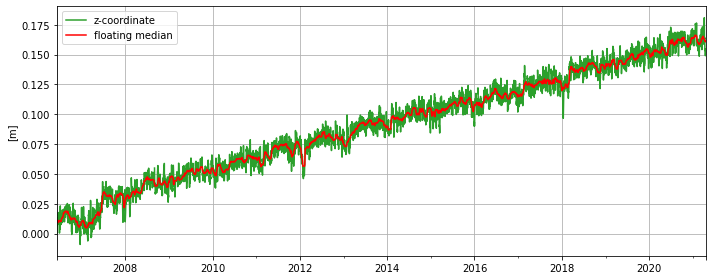

In [14]:
# plot
plt.figure()
station1['up(m)'].plot(figsize=(10, 4), label='z-coordinate', ylabel='[m]', color='tab:green')
station1['median_u'].plot(label='floating median', grid=True, color='r')
plt.legend()
plt.tight_layout()

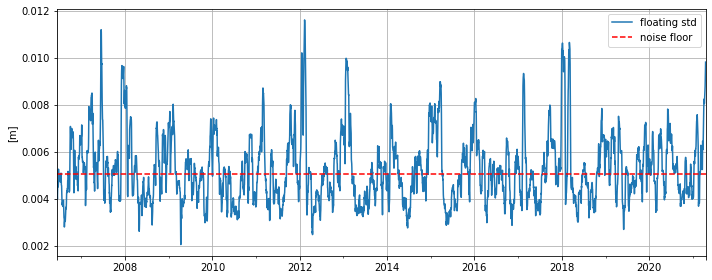

In [15]:
# calculate floating std, then take median to get noise floor
col_std = ['std_e', 'std_n', 'std_u']
station1[col_std] = station1[col_enu].rolling(window=30, center=True, min_periods=15).std()
station2[col_std] = station2[col_enu].rolling(window=30, center=True, min_periods=15).std()
# noise floor
noise_floor_1 = station1[col_std].median()
noise_floor_2 = station2[col_std].median()

# plot
plt.figure()
station1['std_u'].plot(figsize=(10, 4), label='floating std', grid=True, ylabel=['m'])
plt.axhline(noise_floor_1['std_u'], color='r', linestyle='--', label='noise floor')
plt.legend()
plt.tight_layout()

In [16]:
# subtract floating median of coordinates
station1[['e_diff', 'n_diff', 'u_diff']] = (station1[col_enu].values - station1[col_median].values)
station2[['e_diff', 'n_diff', 'u_diff']] = (station2[col_enu].values - station2[col_median].values)

# if the absolute difference is bigger than 3-times the noise floor, we assume an outlier occurs
station1['outliers_e'] = station1['e_diff'].abs() > 3 * noise_floor_1['std_e']
station1['outliers_n'] = station1['n_diff'].abs() > 3 * noise_floor_1['std_n']
station1['outliers_u'] = station1['u_diff'].abs() > 3 * noise_floor_1['std_u']
station2['outliers_e'] = station2['e_diff'].abs() > 3 * noise_floor_2['std_e']
station2['outliers_n'] = station2['n_diff'].abs() > 3 * noise_floor_2['std_n']
station2['outliers_u'] = station2['u_diff'].abs() > 3 * noise_floor_2['std_u']

# if in one coordinate an outlier occurs, we flag all three coordinates as outlier
station1['outliers'] = station1[['outliers_e', 'outliers_n', 'outliers_u']].any(axis=1)
station2['outliers'] = station2[['outliers_e', 'outliers_n', 'outliers_u']].any(axis=1)
station1.head()

east(m)  north(m)     up(m)  median_e  median_n  median_u  \
2006-06-09  0.000000  0.000000  0.000000  0.000628  0.001760  0.010682   
2006-06-10 -0.000210  0.001234  0.002313  0.000628  0.001760  0.010682   
2006-06-11 -0.000092  0.000858  0.009233  0.000458  0.001774  0.010356   
2006-06-12       NaN       NaN       NaN  0.000299  0.001788  0.010682   
2006-06-13  0.001980  0.001471  0.013077  0.000293  0.001774  0.011010   

               std_e     std_n     std_u    e_diff    n_diff    u_diff  \
2006-06-09       NaN       NaN       NaN -0.000628 -0.001760 -0.010682   
2006-06-10  0.000788  0.001547  0.004353 -0.000838 -0.000526 -0.008369   
2006-06-11  0.000768  0.001524  0.004224 -0.000550 -0.000916 -0.001123   
2006-06-12  0.000746  0.001476  0.004292       NaN       NaN       NaN   
2006-06-13  0.000808  0.001435  0.004208  0.001687 -0.000303  0.002067   

            outliers_e  outliers_n  outliers_u  outliers  
2006-06-09       False       False       False     False  
2006-06-10       False       False       False     False  
2006-06-11       False       False       False     False  
2006-06-12       False       False       False     False  
2006-06-13       False       False       False     False

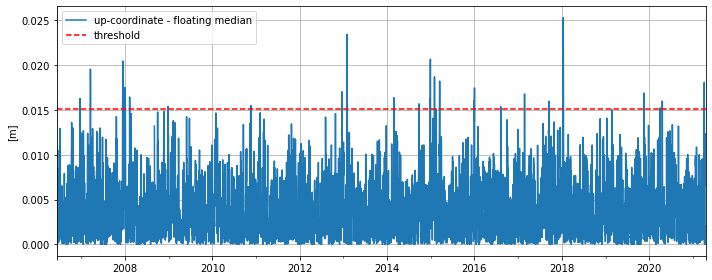

In [17]:
# plot
plt.figure()
station1['u_diff'].abs().plot(figsize=(10, 4), label='up-coordinate - floating median', ylabel='[m]', grid=True)
plt.axhline(3*noise_floor_1['std_u'], color='r', linestyle='--', label='threshold')
plt.legend()
plt.tight_layout()

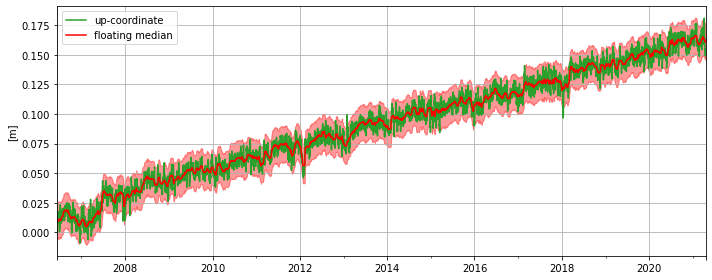

In [18]:
# plot
plt.figure()
station1['up(m)'].plot(figsize=(10, 4), label='up-coordinate', ylabel='[m]', color='tab:green')
station1['median_u'].plot(label='floating median', grid=True, color='r')
plt.fill_between(station1['median_u'].index, station1['median_u']+3*noise_floor_1['std_u'], station1['median_u']-3*noise_floor_1['std_u'], color='r', alpha=0.4)
plt.legend()
plt.tight_layout()

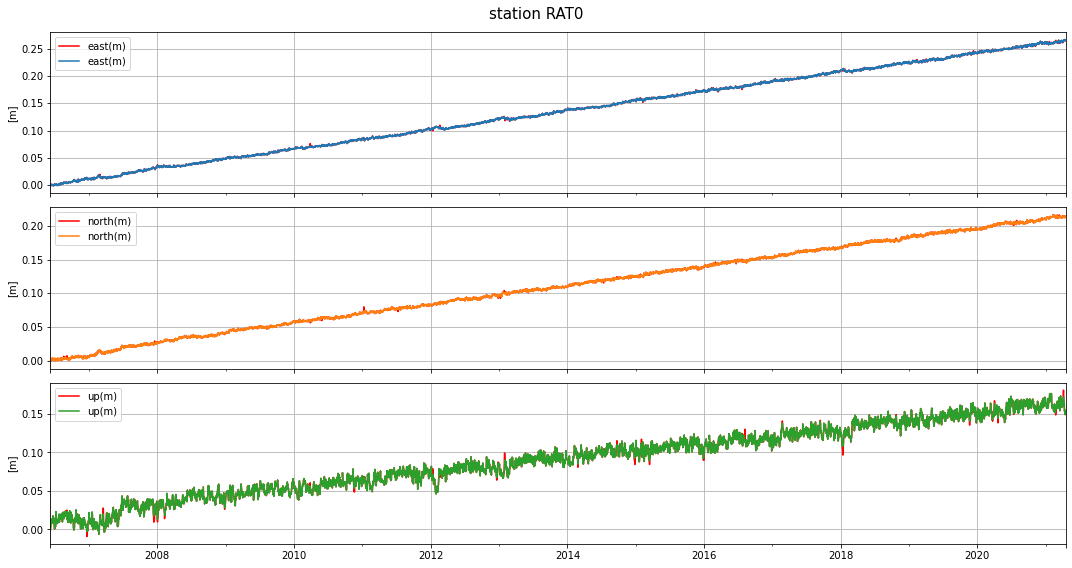

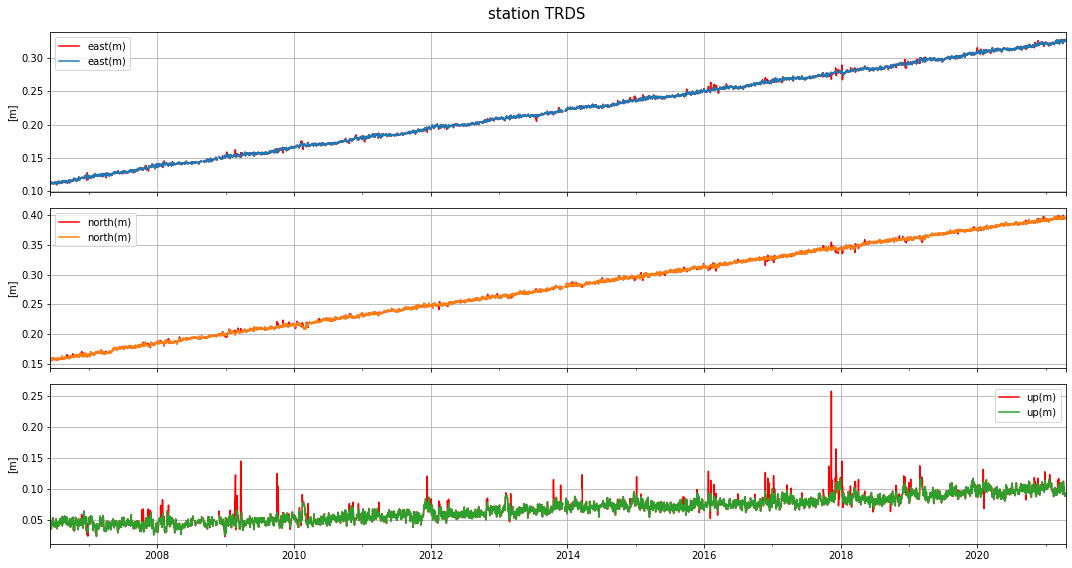

In [19]:
# plot
(ax1, ax2, ax3) = station1[col_enu].plot(subplots=True, figsize=(15, 8), color='r', ylabel=['m'])
# delete outliers
station1 = station1[~station1['outliers']]
station1[col_enu].plot(subplots=True, ax=(ax1, ax2, ax3), color=['C0', 'C1', 'C2'], linewidth=1.5, grid=True)
plt.suptitle('station RAT0', fontsize=15)
plt.tight_layout()

(ax1, ax2, ax3) = station2[col_enu].plot(subplots=True, figsize=(15, 8), color='r', ylabel=['m'])
# delete outliers
station2 = station2[~station2['outliers']]
station2[col_enu].plot(subplots=True, ax=(ax1, ax2, ax3), color=['C0', 'C1', 'C2'], linewidth=1.5, grid=True)
plt.suptitle('station TRDS', fontsize=15)
plt.tight_layout()

# Now we can start with the actual task ...
**$\rightarrow$ How much is the GIA of these two stations?**

In [20]:
station1 = station1[col_enu]
station2 = station2[col_enu]
# drop NaN values
station1.dropna(inplace=True)  
station2.dropna(inplace=True)

# Calculate trend
$trend=slope \cdot x+intercept$

You can use the _linregress()_ function of scipy or you use _Polynomial.fit()_ of numpy

In [21]:
# calculate trend using scipy.stats.linregress() 
station1['days'] = date2num(station1.index)
res = stats.linregress(x=station1['days'], y=station1['up(m)'])
station1['up_fit'] = res.intercept + res.slope*station1['days']
trend_1 = res.slope * 365.2425 * 1000  # [mm/year]

station2['days'] = date2num(station2.index)
res = stats.linregress(x=station2['days'], y=station2['up(m)'])
station2['up_fit'] = res.intercept + res.slope*station2['days']
trend_2 = res.slope * 365.2425 * 1000  # [mm/year]

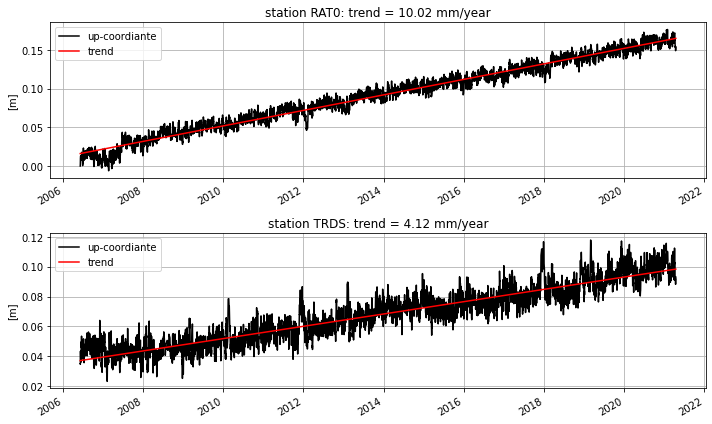

In [22]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
station1['up(m)'].plot(ax=ax1, title='station RAT0: trend = {:.2f} mm/year'.format(trend_1), label='up-coordiante', ylabel='[m]', color='k')
station1['up_fit'].plot(ax=ax1, color='r', grid=True, label='trend')
station2['up(m)'].plot(ax=ax2, title='station TRDS: trend = {:.2f} mm/year'.format(trend_2), label='up-coordiante', ylabel='[m]', color='k')
station2['up_fit'].plot(ax=ax2, color='r', grid=True, label='trend')
ax1.legend()
ax2.legend()
plt.tight_layout()

In [23]:
# calculate trend using np.polynomial.polynomial.Polynomial.fit()
station1['days'] = date2num(station1.index)
poly = np.polynomial.polynomial.Polynomial.fit(x=station1['days'], y=station1['up(m)'], deg=1)
station1['up_fit'] = poly(station1['days'])
trend_1 = poly.coef[0] * 365.2425 * 1000  # [mm/year]
coef = poly.convert().coef
trend_1 = coef[1] * 365.2425 * 1000  # [mm/year]

station2['days'] = date2num(station2.index)
poly = np.polynomial.polynomial.Polynomial.fit(x=station2['days'], y=station2['up(m)'], deg=1)
station2['up_fit'] = poly(station2['days'])
coef = poly.convert().coef
trend_2 = coef[1] * 365.2425 * 1000  # [mm/year]

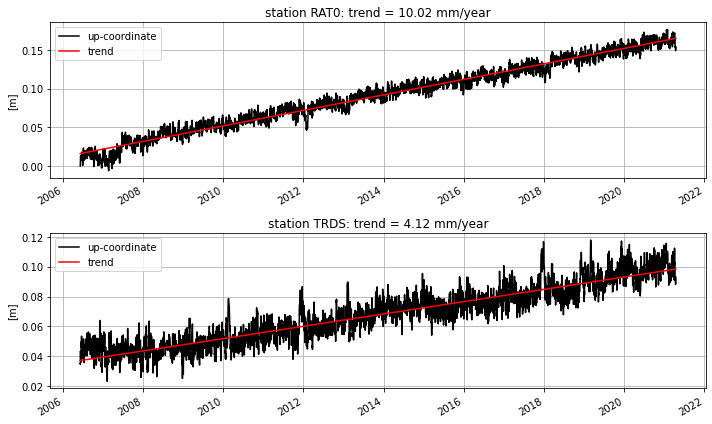

In [24]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
station1['up(m)'].plot(ax=ax1, title='station RAT0: trend = {:.2f} mm/year'.format(trend_1), label='up-coordinate', ylabel='[m]', color='k')
station1['up_fit'].plot(ax=ax1, color='r', grid=True, label='trend')
station2['up(m)'].plot(ax=ax2, title='station TRDS: trend = {:.2f} mm/year'.format(trend_2), label='up-coordinate', ylabel='[m]', color='k')
station2['up_fit'].plot(ax=ax2, color='r', grid=True, label='trend')
ax1.legend()
ax2.legend()
plt.tight_layout()

# Any questions?